## Mid-price estimation for European corporate bonds: a particle filtering approach
Olivier Guéant, Jiang Pu \\
Code by Xavier Brouty

In [ ]:
!pip install particles

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 4.3 MB/s 
  Created wheel for particles: filename=particles-0.3-py3-none-any.whl size=84625 sha256=98bbe0b730ac32038dede1b464dcb45044a8533bbb04d582188899685b77ad34
  Stored in directory: /root/.cache/pip/wheels/bd/36/36/8606ee9557117b4f3ca1b9be4b089c6095351349146f9d6e68
Successfully built particles


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from scipy import stats
import pandas as pd 

import particles
from particles import smc_samplers as ssp
from particles import state_space_models as ssm
from particles import distributions as dists

## Principal parameters of the algorithm

In [ ]:
sigma_1 = 0.5
sigma_2 = 0.62
sigma_3 = 0.69
rho_1_2 = 0.843
rho_1_3 = 0.835 
rho_2_3 = 0.887
cov_1_2 = rho_1_2*sigma_1*sigma_2 
cov_1_3 = rho_1_3*sigma_1*sigma_3 
cov_2_3 = rho_2_3*sigma_2*sigma_3 
cov_matrix = np.array([[sigma_1**2,cov_1_2,cov_1_3],[cov_1_2,sigma_2**2,cov_2_3],[cov_1_3,cov_2_3,sigma_3**2]])
cor_matrix = np.array([[sigma_1,rho_1_2,rho_1_3],[rho_1_2,sigma_2,rho_2_3],[rho_1_3,rho_2_3,sigma_3]])

mean_bas_1 = 0.79
mean_bas_2 = 0.73
mean_bas_3 = 0.65
sigma_epsilon = [mean_bas_1*0.005,mean_bas_2*0.005,mean_bas_3*0.005]
y0 = np.array([10,9,8])
ratio_alpha = 0.5
x0 = 0.0005 * y0

## Simulation of the data

In [ ]:
def data_next_step(yp, xp, cov_matrix_y, A, V, sigma_epsilon, action):
  d = len(yp)
  tab_observation = np.zeros(3)
  observation = np.zeros(3)
  s = np.array([cov_matrix[0,0],cov_matrix[1,1],cov_matrix[2,2]])
  y_t = dists.MvNormal(loc=yp,scale=s,cov=cov_matrix).rvs(1).squeeze()
  x_t = xp - np.dot(A,xp) + V @ np.random.normal(size=d)
  epsilon_t = np.random.multivariate_normal(mean=np.zeros(d),cov = [[sigma_epsilon[0]**2,0,0],[0,sigma_epsilon[1]**2,0],[0,0,sigma_epsilon[2]**2]])
  if action == 1 :
    observation = y_t - np.exp(x_t) + epsilon_t
  if action == 2 :
    observation = y_t + np.exp(x_t) + epsilon_t
  if action == 3 :
    transaction_price = y_t - np.exp(x_t) + epsilon_t
    observation[0] = dists.TruncNormal(0.975 * transaction_price[0], transaction_price[0] * 0.05, 0.95 * transaction_price[0], transaction_price[0]).rvs(1).squeeze()
    observation[1] = dists.TruncNormal(0.975 * transaction_price[1], transaction_price[1] * 0.05, 0.95 * transaction_price[1], transaction_price[1]).rvs(1).squeeze()
    observation[2] = dists.TruncNormal(0.975 * transaction_price[2], transaction_price[2] * 0.05, 0.95 * transaction_price[2], transaction_price[2]).rvs(1).squeeze()
  if action == 4 :
    transaction_price = y_t + np.exp(x_t) + epsilon_t
    observation[0] = dists.TruncNormal(1.025 * transaction_price[0], transaction_price[0] * 0.05, transaction_price[0], 1.05 * transaction_price[0]).rvs(1).squeeze()
    observation[1] = dists.TruncNormal(1.025 * transaction_price[1], transaction_price[1] * 0.05, transaction_price[1], 1.05 * transaction_price[1]).rvs(1).squeeze()
    observation[2] = dists.TruncNormal(1.025 * transaction_price[2], transaction_price[2] * 0.05, transaction_price[2], 1.05 * transaction_price[2]).rvs(1).squeeze()
  if action == 5 : 
    lower_bound = y_t - ratio_alpha * np.exp(x_t) + epsilon_t
    higher_bound = y_t + ratio_alpha * np.exp(x_t) + epsilon_t 
    observation[0] = dists.TruncNormal(np.mean([lower_bound[0],higher_bound[0]]), lower_bound[0] * 0.05, lower_bound[0], higher_bound[0]).rvs(1).squeeze()
    observation[1] = dists.TruncNormal(np.mean([lower_bound[1],higher_bound[1]]), lower_bound[1] * 0.05, lower_bound[1], higher_bound[1]).rvs(1).squeeze()
    observation[2] = dists.TruncNormal(np.mean([lower_bound[2],higher_bound[2]]), lower_bound[2] * 0.05, lower_bound[2], higher_bound[2]).rvs(1).squeeze()
  tab_observation[0] = observation[0]
  tab_observation[1] = observation[1]
  tab_observation[2] = observation[2]
  return tab_observation, y_t, x_t



In [ ]:
def essai_simulation(y0, cov_matrix_y, V, sigma_epsilon, T, A, gamma, num_bonds):
  d = len(y0)
  tab_y_t = np.zeros((T,d))
  tab_x_t = np.zeros((T,d))
  observation_data = np.zeros((T,d))
  observation_data[0][0] = y0[0]
  observation_data[0][1] = y0[1]
  observation_data[0][2] = y0[2]
  tab_y_t[0][0], tab_y_t[0][1], tab_y_t[0][2] = y0[0], y0[1], y0[2]
  yp = y0
  x0 = np.array(y0) * 0.05
  xp = x0
  tab_x_t[0][0], tab_x_t[0][1], tab_x_t[0][2] = x0[0], x0[1], x0[2]
  for m in range(1,T):
    action = np.random.choice([1,2,3,4,5])  ## We choose a scenario randomly
    tab_observation, yp1, xp1 = data_next_step(yp, xp, cov_matrix_y, A, V, sigma_epsilon,action)
    observation_data[m][0] = tab_observation[0]
    observation_data[m][1] = tab_observation[1]
    observation_data[m][2] = tab_observation[2]
    tab_y_t[m][0], tab_y_t[m][1], tab_y_t[m][2] = yp1[0], yp1[1], yp1[2]
    tab_x_t[m][0], tab_x_t[m][1], tab_x_t[m][2] = xp1[0], xp1[1], xp1[2]
    yp = yp1
    xp = xp1
  return observation_data, tab_y_t, tab_x_t 


In [ ]:
V = np.eye(3) / 10**6
A = np.eye(3)
gamma = [[(1-np.exp(-A[i][i]-A[j][j])/(A[i][i] + A[j][j])) * (V @ V.T)[i][j] for j in range(3)] for i in range(3)]
data_create_essai, tab_y_t, tab_x_t = essai_simulation(y0,cov_matrix,V,sigma_epsilon, 100, A, gamma, 1)

We plot the observed data to see if it can correspond to a path of a YtB.

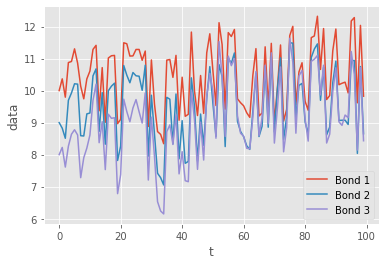

In [ ]:
plt.style.use('ggplot')
plt.plot(data_create_essai[:,0],label='Bond 1')
plt.plot(data_create_essai[:,1],label='Bond 2')
plt.plot(data_create_essai[:,2],label='Bond 3')
plt.xlabel('t')
plt.ylabel('data')
plt.legend()

Here we observe how the YtB mooves with the mid-price of the bond. It gives us information about how the different actions bring noise to the value of the mid-price we want to observe.

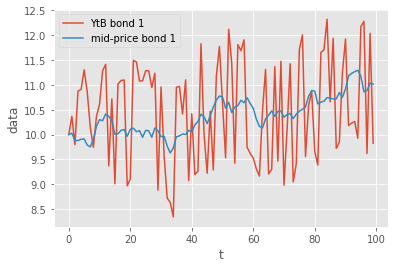

In [ ]:
plt.style.use('ggplot')
plt.plot(data_create_essai[:,0],label='YtB bond 1')
plt.plot(tab_y_t[:,0],label='mid-price bond 1')
plt.xlabel('t')
plt.ylabel('data')
plt.legend()

## Simulation of trajectories by induction

## Step 1 : Drawing half bid-ask spreads


In [ ]:
def draw_half_bid_ask_spread(x_m_m, A, gamma):
  list_psi_hat_m_1= []
  list_x_hat_m_1 = []
  K = np.array(x_m_m).shape[1]
  for i in range(K):
    mean_x_hat_m_1_k = np.dot(np.exp(-A),x_m_m[-1][i])
    x_hat_m_1_k = np.random.multivariate_normal(mean_x_hat_m_1_k,gamma)
    list_x_hat_m_1.append(x_hat_m_1_k)
    psi_hat_m_1_k = np.exp(x_hat_m_1_k)
    list_psi_hat_m_1.append(psi_hat_m_1_k)
  return np.array(list_psi_hat_m_1), np.array(list_x_hat_m_1) 

## Step 2 : Computing weights

The variables in the following function represent :     

num_bonds : the number of the bonds observed at the time of the study.

hat_psi : an element coming from the function draw_half_bid_ask_spread. It represents $\hat{ψ}_{m+1,k}$.

data : the value of the observation of the market maker.

y_m_m : the matrix containing the $((y_{n,k}^m)_{0\le n \le m})_{1 \le k \le K} $ meaning that the matrix has $m$ rows and $K$ columns and the element in the $n^{th}$ row and the $k^{th}$ column is the vector $y_{n,k}^m$ which is a vector of dimension $d$.

action : one of the 5 actions depicted by the $J_{\tau}$ notation.

In [ ]:
def compute_weights(num_bonds, hat_psi, data, y_m_m, action):  ## hat_psi comes from the draw_half_bid_ask_spread function
  list_weights=[]
  K = len(hat_psi)
  if action == 1 :
    for k in range(K) :
      list_weights.append(stats.norm.pdf((data[num_bonds] + hat_psi[k][num_bonds] - y_m_m[-1][k][num_bonds]) / (np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds]))))

  if action == 2 :
    for k in range(K) :
      list_weights.append(stats.norm.pdf((data[num_bonds] - hat_psi[k][num_bonds] - y_m_m[-1][k][num_bonds]) / (np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds]))))

  if action == 3 :
    for k in range(K) :
      list_weights.append(stats.norm.cdf(-(data[num_bonds] + hat_psi[k][num_bonds] - y_m_m[-1][k][num_bonds])/(np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds])))) 

  if action == 4 :
    for k in range(K):
      list_weights.append(stats.norm.cdf((data[num_bonds] - hat_psi[k][num_bonds] - y_m_m[-1][k][num_bonds]) / (np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds]))))

  if action == 5 :
    for k in range(K):
      first_term = stats.norm.cdf((data[num_bonds] + ratio_alpha * hat_psi[k][num_bonds] - y_m_m[-1][k][num_bonds]) / (np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds])))
      second_term = stats.norm.cdf((data[num_bonds] - ratio_alpha * hat_psi[k][num_bonds] - y_m_m[-1][k][num_bonds]) / (np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds])))
      list_weights.append(first_term - second_term)

  return np.array(list_weights)

## Step 3-4-5-6 : Resampling and drawing of $\tilde y_{τ_{m+1}}^i$, $y_{τ_{m+1}}^i$ and $(y_{τ_{m+1}}^{i'})_{1\le i'\neq i\le d}$

In [ ]:
from particles import resampling as rs 

The variables in the following function represent : 


weights : the list of the $K$ weights with $\forall k \in \{1,\cdots,k\}, w_k = \frac{ω_k}{\sum_{k'=1}^{K} ω_{k'}}$.

x_m_m : the matrix containing the $((x_{n,k}^m)_{0\le n \le m})_{1 \le k \le K} $ meaning that the matrix has $m$ rows and $K$ columns and the element in the $n^{th}$ row and the $k^{th}$ column is the vector $x_{n,k}^m$ which is a vector of dimension $d$.

y_m_m : the matrix containing the $((y_{n,k}^m)_{0\le n \le m})_{1 \le k \le K} $ meaning that the matrix has $m$ rows and $K$ columns and the element in the $n^{th}$ row and the $k^{th}$ column is the vector $y_{n,k}^m$ which is a vector of dimension $d$.

hat_x : an element coming from the function draw_half_bid_ask_spread. It represents $\hat{x}_{m+1,k}$.

num_bonds : the number of the bonds observed at the time of the study.

action : one of the 5 actions depicted by the $J_{\tau}$ notation.

data : the value of the observation of the market maker. 

In [ ]:
def resampling_drawing(weights, x_m_m, y_m_m, hat_x, num_bonds, action, data):  ## hat_x comes from the draw_half_bid_ask_spread function
  weights = np.array(weights) / np.sum(np.array(weights))    ## We normalize the weights coming from the compute_weights function
  k = np.array(y_m_m).shape[1]
  m = np.array(y_m_m).shape[0]
  d = np.array(y_m_m).shape[2]
  bool_resample = False
  list_w_hat = []
  if pd.isna(weights[0]):
    weights = np.array([1/k for i in range(k)])
  if rs.essl(np.log(weights))< k/2 :  ## We resample if ESS < k/2 with k the number of particles
    list_idx = rs.systematic(weights, len(weights))  ## We use the systematic resampling. In the book An Introduction to Sequential Monte Carlo by Nicolas Chopin and 
    ## Omiros Papaspiliopoulos in the part 9.7 it is stated that the systematic resampling is often recommended by practitioners
    bool_resample = True
  else:
    list_idx = np.arange(0,k)
  s = np.array([cor_matrix[0,0],cor_matrix[1,1],cor_matrix[2,2]])
  y_m1_m1 = np.array([[[0.0 for l in range(3)] for j in range(k)] for i in range(m+1)])
  x_m1_m1 = np.array([[[0.0 for l in range(3)] for j in range(k)] for i in range(m+1)])
  psi_m1_m1 = np.array([[[0.0 for l in range(3)] for j in range(k)] for i in range(m+1)])
  list_y_tilde_tau_m1 = []
  for i in range(m):
    for j in range(k):
      idx_res = np.random.choice(list_idx)  ## Here we take an observation for the random variable \xi_{m+1} (k)
      if i == m-1:
        list_w_hat.append(idx_res)
      ## Then we take the value for the resampling
      y_m1_m1[i][j] = y_m_m[i][idx_res]
      x_m1_m1[i][j] = x_m_m[i][idx_res]
      psi_m1_m1[i][j] = np.exp(x_m1_m1[i][j])
      x_m1_m1[-1][j] = hat_x[idx_res]
      psi_m1_m1[-1][j] = np.exp(x_m1_m1[-1][j])
  for j in range(k):
    ## Here it remains to define y_m1_m1[-1]
    ## Drawing of y_tilde_tau_m1 for the bonds num_bonds, it corresponds to the step 4 in the article
    if action == 1 :
      list_y_tilde_tau_m1.append(data[num_bonds] + psi_m1_m1[-1][j][num_bonds])
    if action == 2 :
      list_y_tilde_tau_m1.append(data[num_bonds] - psi_m1_m1[-1][j][num_bonds])
    if action == 3:
      mu = y_m1_m1[m][j][num_bonds]
      sigma = np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds])
      a = data[num_bonds] + psi_m1_m1[-1][j][num_bonds]
      compt=0
      while True:  ## This loop is implemented because it is sometimes possible that the "dists.TruncNormal" function returns an error due to the domain we give
      ## in the parameters. So we coded this to moove the high and low bounds in order to have a value at the end of the loop. We do this for all the action recquiring 
      ## the use of the TruncNormal function
        try :
          list_y_tilde_tau_m1.append(dists.TruncNormal(mu, sigma,a-compt,a + 3*sigma+compt).rvs(1).squeeze())
          break
        except ValueError:
          compt += 0.005
    if action == 4:
      mu = y_m1_m1[m][j][num_bonds]
      sigma = np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds])
      b = data[num_bonds] - psi_m1_m1[-1][j][num_bonds]
      compt=0
      while True:
        try :
          list_y_tilde_tau_m1.append(dists.TruncNormal(mu, sigma,b-3*sigma -compt,b+compt).rvs(1).squeeze())
          break
        except ValueError:
          compt += 0.005
    if action == 5:
      mu = y_m1_m1[m][j][num_bonds]
      sigma = np.sqrt(cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds])
      a = data[num_bonds] - psi_m1_m1[-1][j][num_bonds] * ratio_alpha 
      b = data[num_bonds] + psi_m1_m1[-1][j][num_bonds] * ratio_alpha 
      compt=0
      while True:
        try :
          list_y_tilde_tau_m1.append(dists.TruncNormal(mu, sigma,a-compt,b+compt).rvs(1).squeeze())
          break
        except ValueError:
          compt += 0.005
          
    ## Drawing of y_tau_m1 for the bonds num_bonds
    mu = (cov_matrix[num_bonds][num_bonds] * list_y_tilde_tau_m1[j] + sigma_epsilon[num_bonds] * y_m1_m1[-2][j][num_bonds]) / (cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds])
    sigma = (cov_matrix[num_bonds][num_bonds] * sigma_epsilon[num_bonds]) / (cov_matrix[num_bonds][num_bonds] + sigma_epsilon[num_bonds])
    y_m1_m1[-1][j][num_bonds] = np.random.normal(loc=mu,scale=sigma)
    other_bonds = [ele for ele in range(d) if ele!=num_bonds]
    mu_k_i = np.array([y_m1_m1[-2][j][ele] for ele in range(len(y_m1_m1[-2][j])) if ele!=num_bonds]) + (y_m1_m1[-1][j][num_bonds] - y_m1_m1[-2][j][num_bonds]) * np.array([cor_matrix[ele][num_bonds]*((cor_matrix[ele][ele])/cor_matrix[num_bonds][num_bonds]) for ele in other_bonds])
    column_i = np.array([cor_matrix[num_bonds][ele_i]*cor_matrix[ele_i][ele_i] for ele_i in other_bonds])
    sigma_i = [[cov_matrix[ele_i][ele_j] for ele_j in range(d) if ele_j != num_bonds]for ele_i in range(d) if ele_i != num_bonds] - np.outer(column_i,column_i)
    vector_i_prime = np.random.multivariate_normal(mean=mu_k_i,cov = sigma_i)
    compt = 0
    for ele_bonds in other_bonds:
      y_m1_m1[-1][j][ele_bonds] = vector_i_prime[compt]
      compt+=1 
  return y_m1_m1, x_m1_m1, psi_m1_m1, bool_resample, list_w_hat


The next function computes one of a criterion we will see later in the notebook to evaluates how much resampling degrades the approximation brought by importance sampling.

In [ ]:
def compute_criterion(list_W, list_w_hat):
  criterion = 0.0
  N = len(list_W)
  dic_count = {item:list_w_hat.count(item) for item in list_w_hat}
  for n in range(N):
    if n in dic_count.keys():
      criterion += np.abs(N * list_W[n] - dic_count[n])
    else:
      criterion += N * list_W[n]
  return criterion / (2*N)

Again the notation for the following function called simulate are :    

y0 : the vector of the mid YtB of the bonds at time 0.

cov_matrix_y : the covariance matrix of the mid YtB.

V : the matrix of size $d \times d$ coming from the Ornstein-Ulhenbeck process.

sigma_epsilon : the vector of variance for the noise added to the observations.

x_0_0 : the matrix from the prior distribution.

y_0_0 : the matrix from the prior distribution.

T : the period of the study.

A : the matrix of size $d \times d$ coming from the Ornstein-Ulhenbeck process.

gamma : the matrix with $\Gamma^{i,j} (\tau) = \frac{1}{a^{i} + a^{j}}(1 - \exp(-(a^{i} + a^{j})\tau))(VV')^{i,j}$

We then follow the above steps recursively

In [ ]:
from tqdm import tqdm
def simulate(y0, cov_matrix_y, V, sigma_epsilon, x_0_0, y_0_0, T, A, gamma):
  k = x_0_0.shape[1]
  y_T_T = np.array([[[0.0 for l in range(3)] for j in range(k)] for i in range(T)])
  x_T_T = np.array([[[0.0 for l in range(3)] for j in range(k)] for i in range(T)])
  x_m_m = x_0_0
  y_m_m = y_0_0
  psi_m_m = y_0_0
  d = len(y0)
  y_T_T[0] = y_0_0[0]
  x_T_T[0] = y_T_T[0]
  observation_data = np.zeros((T,d))
  observation_data[0][0] = y0[0]
  observation_data[0][1] = y0[1]
  observation_data[0][2] = y0[2]
  yp = y0
  x0 = np.array(y0) * 0.05
  xp = x0
  list_action = [-1]
  list_num_bonds = [-1]
  list_ESS = []
  list_weights = [[1/k for i in range(k)]]
  list_resample = []
  list_criterion = []
  for m in tqdm(range(1,T)):
    num_bonds = np.random.choice([0,1,2])  ## We choose a bond randomly at the time t
    list_num_bonds.append(num_bonds)
    list_psi_hat_m_1, list_x_hat_m_1 = draw_half_bid_ask_spread(x_m_m, A, gamma) ## Step 1 of the algorithm
    action = np.random.choice([1,2,3,4,5])  ## We choose a scenario randomly
    list_action.append(action)
    tab_observation, yp1, xp1 = data_next_step(yp, xp, cov_matrix_y, A, V, sigma_epsilon,action)  ## Computation of the data at the time of the observation
    observation_data[m][0] = tab_observation[0]
    observation_data[m][1] = tab_observation[1]
    observation_data[m][2] = tab_observation[2]
    weights = compute_weights(num_bonds, list_psi_hat_m_1, observation_data[m], y_m_m,action) ## Step 2 of the algorithm
    weights2 = np.array(weights) / np.sum(np.array(weights))
    if pd.isna(weights2[0]):
      list_weights.append(np.array([1/k for i in range(k)]))
    else:
      list_weights.append(weights2)
    list_ESS.append(rs.essl(np.log(weights2)))
    y_m1_m1,x_m1_m1,psi_m1_m1, bool_resample, list_w_hat = resampling_drawing(weights, x_m_m, y_m_m, list_x_hat_m_1, num_bonds, action, observation_data[m])  ## Step 3,4,5 and 6 of the algorithm
    if bool_resample == True:
      list_resample.append(m)
      criterion = compute_criterion(list_weights[m], list_w_hat)
      list_criterion.append(criterion)
    y_m_m = y_m1_m1
    x_m_m = x_m1_m1
    yp = yp1
    xp = xp1
    y_T_T[m] = y_m_m[-1]
    x_T_T[m] = x_m_m[-1]
  return y_m_m, x_m_m, psi_m_m, np.array(list_action), observation_data, y_T_T, x_T_T, np.array(list_num_bonds), np.array(list_ESS), np.array(list_weights), np.array(list_resample), np.array(list_criterion)




We first need to draw K particles to build a K-sample $((y_{0,k}^0,x_{0,k}^0,\psi_{0,k}^0)_{1\le k\le K})$ (this case corresponds to the prior distribution)

We want to have :     
$\mathbb{E} (\psi_1) = \sqrt{\mathbb{Var}(\psi_1)} = 0.79$ \\
$\mathbb{E} (\psi_2) = \sqrt{\mathbb{Var}(\psi_2)} = 0.73$ \\
$\mathbb{E} (\psi_3) = \sqrt{\mathbb{Var}(\psi_3)} = 0.65$ \\
So, to have these values for the two first moments we need to have :    \\
$x_1 \sim \mathcal{N}(\mu_1,\,\sigma_1^{2})$ with $\mu_1 = \ln\left(\frac{\mathbb{E} (\psi_1)^2}{\sqrt{\mathbb{E} (\psi_1)^2 + \mathbb{Var}(\psi_1)}}\right)$ \\
$x_2 \sim \mathcal{N}(\mu_2,\,\sigma_2^{2})$ with $\mu_2 = \ln\left(\frac{\mathbb{E} (\psi_2)^2}{\sqrt{\mathbb{E} (\psi_2)^2 + \mathbb{Var}(\psi_2)}}\right)$ \\
$x_3 \sim \mathcal{N}(\mu_3,\,\sigma_3^{2})$ with $\mu_3 = \ln\left(\frac{\mathbb{E} (\psi_3)^2}{\sqrt{\mathbb{E} (\psi_3)^2 + \mathbb{Var}(\psi_3)}}\right)$ \\


In [ ]:
K = 1000
y0 = np.array([10,9,8])
x0 = 0.0005 * y0
mu_1 = np.log((mean_bas_1**2) / np.sqrt(2 * mean_bas_1**2))
sigma_1 = np.log(2)
x_0_0_1 = dists.TruncNormal(mu_1, sigma_1,-5,0).rvs(K) ## The prior is a bit different that what we computed in the cell above because if we do not use a truncated normal law then we have high values in the algorithm
## and those high values can give computation errors while running the algorithm 
mu_2 = np.log((mean_bas_2**2) / np.sqrt(2 * mean_bas_2**2))
sigma_2 = np.log(2)
x_0_0_2 = dists.TruncNormal(mu_2, sigma_2,-5,0).rvs(K)
mu_3 = np.log((mean_bas_3**2) / np.sqrt(2 * mean_bas_3**2))
sigma_3 = np.log(2)
x_0_0_3 = dists.TruncNormal(mu_3, sigma_3,-5,0).rvs(K)
x_0_0 = np.array([[[0.0 for i in range(3)] for k in range(K)]])
x_0_0[0][:,0] = x_0_0_1
x_0_0[0][:,1] = x_0_0_2 
x_0_0[0][:,2] = x_0_0_3
y_0_0 = np.array([np.random.multivariate_normal(mean = y0, cov = cov_matrix,size=K)])


The next cell is the one that combines all the previous functions to compute the value we want to observe

In [ ]:
V = np.eye(3) / 10**6
A = np.eye(3)
gamma = np.array([[(1-np.exp(-A[i][i]-A[j][j])/(A[i][i] + A[j][j])) * (V @ V.T)[i][j] for j in range(3)] for i in range(3)]) / 1000
y_m_m_test, x_m_m_test, psi_m_m_test, list_action_test, observation_data_test, y_T_T_test, x_T_T_test, list_num_bonds_test, list_ESS_test, list_weights_test, list_resample_test, list_criterion_test = simulate(y0, cov_matrix, V, sigma_epsilon,x_0_0, y_0_0, 100, A, gamma)

  9%|▉         | 9/99 [00:06<01:05,  1.38it/s]<ipython-input-11-01512172f416>:36: RuntimeWarning: invalid value encountered in true_divide
  weights2 = np.array(weights) / np.sum(np.array(weights))
<ipython-input-9-1420d6dd831e>:2: RuntimeWarning: invalid value encountered in true_divide
  weights = np.array(weights) / np.sum(np.array(weights))    ## We normalize the weights coming from the compute_weights function
100%|██████████| 99/99 [03:05<00:00,  1.87s/it]


In [ ]:
def plot_style(y_m_m, list_action, observation_data, y_T_T, list_num_bonds, num_bonds):
  y_mean_1 = []
  y_25p_1 = []
  y_75p_1 = []
  y_10p_1 = []
  y_90p_1 = []
  y_5p_1 = []
  y_95p_1 = []
  y_1p_1 = []
  y_99p_1 = []
  for t in range(y_m_m.shape[0]):
    y_mean_1.append(np.mean(y_T_T[t][:,num_bonds]))
    y_25p_1.append(np.percentile(y_T_T[t][:,num_bonds],25))
    y_75p_1.append(np.percentile(y_T_T[t][:,num_bonds],75))
    y_10p_1.append(np.percentile(y_T_T[t][:,num_bonds],10))
    y_90p_1.append(np.percentile(y_T_T[t][:,num_bonds],90))
    y_5p_1.append(np.percentile(y_T_T[t][:,num_bonds],5))
    y_95p_1.append(np.percentile(y_T_T[t][:,num_bonds],95))
    y_1p_1.append(np.percentile(y_T_T[t][:,num_bonds],1))
    y_99p_1.append(np.percentile(y_T_T[t][:,num_bonds],99))

  observation_data_1 = observation_data[:,num_bonds]
  tab_1 = np.array([(i,observation_data_1[i]) for i in range(1,len(observation_data_1)) if list_action[i]==1 and list_num_bonds[i]==num_bonds])
  tab_2 = np.array([(i,observation_data_1[i]) for i in range(1,len(observation_data_1)) if list_action[i]==2 and list_num_bonds[i]==num_bonds])
  tab_3 = np.array([(i,observation_data_1[i]) for i in range(1,len(observation_data_1)) if list_action[i]==3 and list_num_bonds[i]==num_bonds])
  tab_4 = np.array([(i,observation_data_1[i]) for i in range(1,len(observation_data_1)) if list_action[i]==4 and list_num_bonds[i]==num_bonds])
  tab_5 = np.array([(i,observation_data_1[i]) for i in range(1,len(observation_data_1)) if list_action[i]==5 and list_num_bonds[i]==num_bonds])
  plt.plot(y_mean_1, '-', color='black')
  plt.fill_between(np.arange(len(y_mean_1)), y_25p_1, y_75p_1,
                     alpha=0.4, color='purple')
  plt.fill_between(np.arange(len(y_mean_1)), y_75p_1, y_90p_1,
                     alpha=0.3, color='purple')
  plt.fill_between(np.arange(len(y_mean_1)), y_10p_1, y_25p_1,
                     alpha=0.3, color='purple')
  plt.fill_between(np.arange(len(y_mean_1)), y_90p_1, y_95p_1,
                     alpha=0.2, color='purple')
  plt.fill_between(np.arange(len(y_mean_1)), y_10p_1, y_5p_1,
                     alpha=0.2, color='purple')
  plt.fill_between(np.arange(len(y_mean_1)), y_95p_1, y_99p_1,
                     alpha=0.1, color='purple')
  plt.fill_between(np.arange(len(y_mean_1)), y_5p_1, y_1p_1,
                     alpha=0.1, color='purple')
  if len(tab_1)!=0:
    plt.plot(tab_1[:,0],tab_1[:,1],'o',color='green',label='Done (Sell)')
  if len(tab_2)!=0:  
    plt.plot(tab_2[:,0],tab_2[:,1],'o',color='red',label='Done (Buy)')
  if len(tab_3)!=0:
    plt.plot(tab_3[:,0],tab_3[:,1],'+',color='green',label='Traded Away (Sell)')
  if len(tab_4)!=0:
    plt.plot(tab_4[:,0],tab_4[:,1],'+',color='red',label='Traded Away (Buy)')
  if len(tab_5)!=0:
    plt.plot(tab_5[:,0],tab_5[:,1],'o',color='black',label='D2D Trade')
  plt.title("bond "+str(num_bonds + 1))
  plt.xlabel("business time in days")
  plt.legend(loc ="lower left")

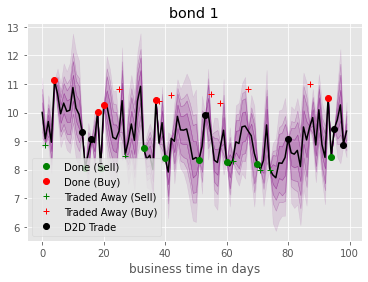

In [ ]:
plot_style(y_m_m_test, list_action_test, observation_data_test, y_T_T_test, list_num_bonds_test, 0)

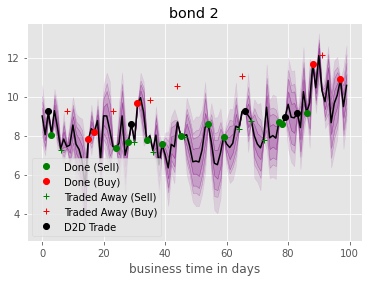

In [ ]:
plot_style(y_m_m_test, list_action_test, observation_data_test, y_T_T_test, list_num_bonds_test, 1)

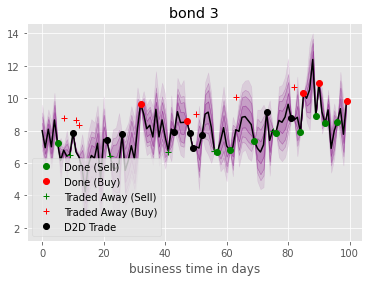

In [ ]:
plot_style(y_m_m_test, list_action_test, observation_data_test, y_T_T_test, list_num_bonds_test, 2)

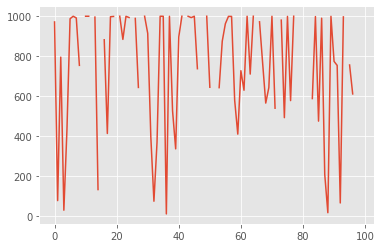

In [ ]:
plt.plot(list_ESS_test)

There is some none values in the plot of the ESS because sometimes the function fails to compute the weights because they are too low. Maybe by implementing the remark 5 of the article we could improve the results on this.

In [ ]:
list_diff = list(np.diff(list_resample_test))
list_diff.insert(0,list_resample_test[0])

Text(0.5, 0, '$t$')

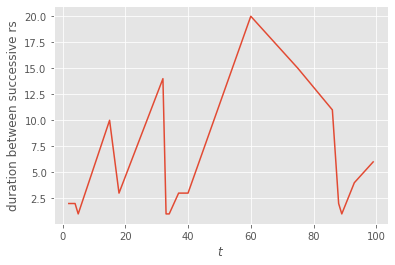

In [ ]:
plt.plot(list_resample_test,list_diff)
plt.ylabel("duration between successive rs")
plt.xlabel("$t$")

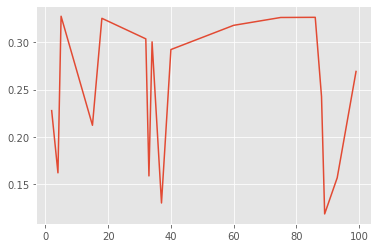

In [ ]:
plt.plot(list_resample_test,list_criterion_test)

We say previously that we do a systematic resample because it is often recommended by practitioners. We are going to verify if it is better to resample with this method. The following cell compute the criterion $\frac{1}{2K}\sum_{k=1}^{K} |KW^k - \tilde{W}^k|$ where $\tilde{W}^k$ is the number of times particle $k$ is resampled. This quantity evaluates how much resampling degrades the approximation brought by importance sampling.

The next cell allows to run the algorithm 30 times with T=100 to compute the criterion and have a distribution of the values it takes. We ran the next cell calling the function simulate with a different resampling to see which one is the best for this task. 

In [ ]:
big_N = 30
df_criterion_tot = pd.DataFrame(columns=np.arange(big_N), index=[0])
for temps in range(big_N):
  y_m_m_test, x_m_m_test, psi_m_m_test, list_action_test, observation_data_test, y_T_T_test, x_T_T_test, list_num_bonds_test, list_ESS_test, list_weights_test, list_resample_test, list_criterion_test = simulate(y0, cov_matrix, V, sigma_epsilon,x_0_0, y_0_0, 100, A, gamma)
  df_criterion_tot[temps].at[0] = list_criterion_test

 19%|█▉        | 19/99 [00:15<01:15,  1.06it/s]<ipython-input-14-01512172f416>:36: RuntimeWarning: invalid value encountered in true_divide
  weights2 = np.array(weights) / np.sum(np.array(weights))
<ipython-input-12-1420d6dd831e>:2: RuntimeWarning: invalid value encountered in true_divide
  weights = np.array(weights) / np.sum(np.array(weights))    ## We normalize the weights coming from the compute_weights function
  4%|▍         | 4/99 [00:02<01:02,  1.52it/s]<ipython-input-14-01512172f416>:41: RuntimeWarning: divide by zero encountered in log
  list_ESS.append(rs.essl(np.log(weights2)))
<ipython-input-12-1420d6dd831e>:10: RuntimeWarning: divide by zero encountered in log
  if rs.essl(np.log(weights))< k/2 :  ## We resample if ESS < k/2 with k the number of particles
100%|██████████| 99/99 [02:54<00:00,  1.76s/it]


In [ ]:
df_criterion_tot.to_pickle('criterion_systematic.pkl')

In [ ]:
df_criterion_residuals = pd.read_pickle("criterion_residuals.pkl")
df_criterion_stratified = pd.read_pickle("criterion_stratified.pkl")
df_criterion_systematic = pd.read_pickle("criterion_systematic.pkl")

In [ ]:
mean_criterion_residuals = []
mean_criterion_stratified = []
mean_criterion_systematic = []
len_residuals = []
len_stratified = []
len_systematic = []
for i in df_criterion_residuals.columns:
  mean_criterion_residuals.append(np.mean(df_criterion_residuals[i].at[0]))
  mean_criterion_stratified.append(np.mean(df_criterion_stratified[i].at[0]))
  mean_criterion_systematic.append(np.mean(df_criterion_systematic[i].at[0]))
  len_residuals.append(len(df_criterion_residuals[i].at[0]))
  len_stratified.append(len(df_criterion_stratified[i].at[0]))
  len_systematic.append(len(df_criterion_systematic[i].at[0]))

In [ ]:
print(np.mean(len_residuals))
print(np.mean(len_stratified))
print(np.mean(len_systematic))

16.133333333333333
16.333333333333332
15.633333333333333


We can see that we resample approximatively the same amount of time for the 3 methods 

Text(0.5, 1.0, 'Boxplot of the criterion')

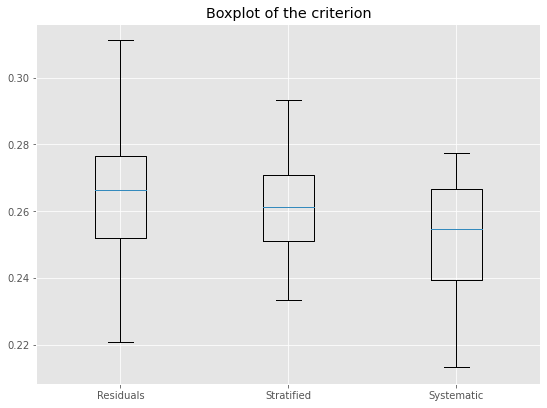

In [ ]:
data = [mean_criterion_residuals, mean_criterion_stratified, mean_criterion_systematic]
fig = plt.figure(figsize =(7, 5))
ax = fig.add_axes([0, 0, 1, 1])

bp=ax.boxplot(data)
ax.set_xticklabels(["Residuals","Stratified","Systematic"])
plt.title("Boxplot of the criterion")